### Price modelling using Brownian Motion

Simple first order linear stochastic differential equation given by:

$ dS_t = \mu S_t + \sigma S_t dW_t $

Has general risk-neutral Itô-adjusted solution:

$ ln \frac{S_t}{S_0} = (r - \frac{\sigma^2}{2})t + \sigma W_t $, where $ W_t $ is a Wiener-Process or Brownian Motion where $ W_{t+\Delta t} - W_t $ ~ $ \sqrt{\Delta t}\mathcal{N}(0,1) $, $ S_0 $ and $ S_t $ is starting price and time-t price respectivly and $ \mu = r $ the risk-free interest rate.

# Geometric Brownian Motion in Matrix Form

We want to simulate \(N\) stock price paths over \(T\) time steps.

---

### 1. Parameters
- Drift (expected return):  
  $
  r \in \mathbb{R}
  $
- Volatility:  
  $
  \sigma \in \mathbb{R}
  $
- Time step:  
  $
  \Delta t = \frac{1}{255}
  $
- Initial stock price:  
  $
  S_0 \in \mathbb{R}
  $
- Number of paths:  
  $
  N
  $
- Number of time steps:  
  $
  T
  $

---

### 2. Random shocks (Brownian increments)
We generate a random Gaussian matrix:
$
W \in \mathbb{R}^{N \times T}, \quad W_{i,j} \sim \mathcal{N}(0,1)
$

This represents the **i-th path’s j-th normal shock**.

---

### 3. Log-increments
For each step $j = 1, \dots, T $, the log increment is:

$
\Delta X_j = \left(r - \tfrac{1}{2}\sigma^2\right)\Delta t \; + \; \sigma \sqrt{\Delta t}\, W_{:,j}
$

Thus the **matrix of log-increments** is:

$
\Delta X \in \mathbb{R}^{N \times T}, \quad \Delta X = \left(r - \tfrac{1}{2}\sigma^2\right)\Delta t \cdot \mathbf{1}_{N \times T} \;+\; \sigma \sqrt{\Delta t}\, W
$

---

### 4. Cumulative log returns
We take row-wise cumulative sums along time:

$
X_{i,j} = \sum_{k=1}^j \Delta X_{i,k}
$

So the **cumulative log-return matrix** is:

$
X \in \mathbb{R}^{N \times T}, \quad X = \text{cumsum}(\Delta X, \text{axis}=1)
$

---

### 5. Stock price paths
Finally, the stock price at step \( j \) is:

$
S_{i,j} = S_0 \, e^{X_{i,j}}
$

To include the initial condition $ S_0 $, we construct:

$
S \in \mathbb{R}^{N \times (T+1)}, \quad 
S = \begin{bmatrix}
S_0 & S_0 e^{X_{1,1}} & S_0 e^{X_{1,2}} & \cdots & S_0 e^{X_{1,T}} \\
S_0 & S_0 e^{X_{2,1}} & S_0 e^{X_{2,2}} & \cdots & S_0 e^{X_{2,T}} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
S_0 & S_0 e^{X_{N,1}} & S_0 e^{X_{N,2}} & \cdots & S_0 e^{X_{N,T}}
\end{bmatrix}
$

---

### 6. Summary (compact formula)
For each path $i \epsilon N$ and time step $j \epsilon T$:

$
S_{i,j} = S_0 \exp\left( \sum_{k=1}^j \left( \left(r - \tfrac{1}{2}\sigma^2\right)\Delta t \;+\; \sigma \sqrt{\Delta t}\, W_{i,k} \right) \right)
$

Or for path $i \epsilon N$ and time step $j \epsilon (T-1)$:

$
S_{i,j+1} = S_{i,j} \exp((r - \tfrac{1}{2}\sigma^2)\Delta t \;+\; \sigma \sqrt{\Delta t}\, W_{i,k})
$


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import statsmodels.api as sm


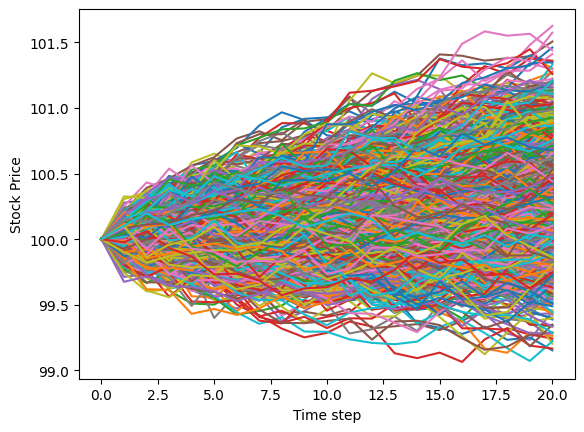

In [205]:
# Parameters
r = 0.0425
sd = 0.015
T = 20  # number of time steps
N = 1000
dt = 1/255
t = np.arange(T+1)
S_0 = 100
K=100

w = np.random.normal(0, 1, size=(N, T))

S_t = np.zeros((N,T+1))
S_t[:,0] = S_0


for i in range(N):
    for j in range(1,T+1):
        S_t[i,j] = S_t[i,j-1]*np.exp((r - 0.5*sd**2)*dt + sd*np.sqrt(dt)*w[i,j-1])


for i in range(N):
    plt.plot(t, S_t[i])
plt.xlabel("Time step")
plt.ylabel("Stock Price")
plt.show()

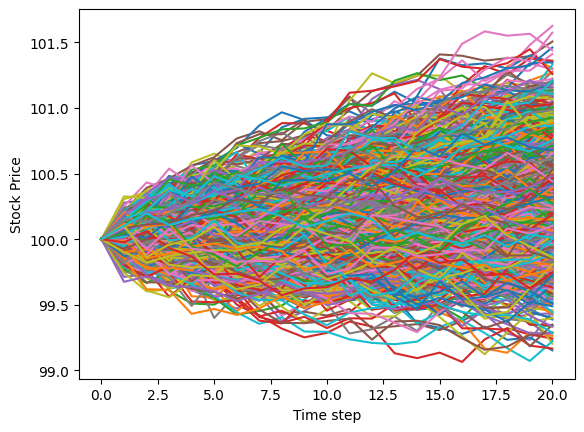

In [206]:
S_t = np.zeros((N,T+1))
S_t[:,0] = S_0

for i in range(N):
    S_t[i,1:] = S_0*np.exp(np.cumsum((r - 0.5 * (sd**2))*dt + sd*np.sqrt(dt)*w[i,:]))

for i in range(N):
    plt.plot(t, S_t[i])
plt.xlabel("Time step")
plt.ylabel("Stock Price")
plt.show()

### Example of NHY

In [172]:
ticker = "NHY"
df = pd.read_csv("OSEBX_Q1Q2_with_indicators.csv", sep=";")
df = df[df["Ticker"] == ticker].reset_index(drop=True)

S = df['Close'].astype(float)
S_lag = S[:-1].reset_index(drop=True)
S = S[1:].reset_index(drop=True)
dS = np.array(S) / np.array(S_lag) - 1

mu = 1/len(S)*np.sum(dS)
sd = np.sqrt(1/(len(S)-1)*np.sum((dS - mu)**2))

(mu, sd)

(-0.0006584158344063746, 0.019562534924587947)

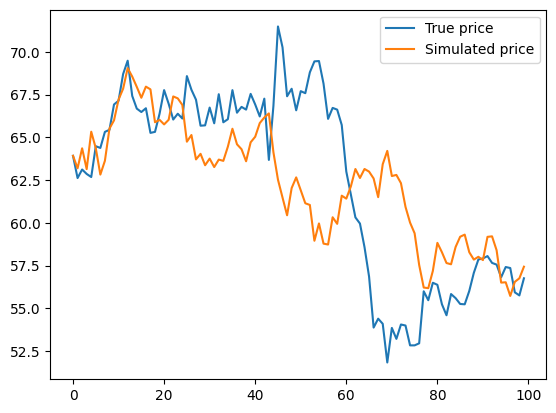

In [207]:
T = 100
S_t_bm = np.zeros(T)
S_t_bm[0] = S_lag[0]

w = np.random.normal(size=T-1)

S_t_bm[1:] = S_t_bm[0]*np.exp(np.cumsum(mu - 0.5 * (sd**2) + sd*w))

plt.plot(range(T), S_lag[:T], label='True price')
plt.plot(range(T), S_t_bm, label='Simulated price')
plt.legend()
plt.show()

# AR(1) Price Dynamics with Drift and Simulation

We model the daily stock price $S_t$ using an autoregressive model of order 1 (AR(1)) with drift and a deterministic time trend:

$
S_t = \alpha + \beta S_{t-1} + \gamma t + \varepsilon_t,
$

where  

- $\alpha$: constant drift (intercept),  
- $\beta$: AR(1) persistence parameter,  
- $\gamma$: linear time trend,  
- $\varepsilon_t \sim \mathcal{N}(0, \sigma^2)$: innovation term (random shock).  

---

## Estimation Procedure

We estimate this model using **ordinary least squares (OLS)**. The regression setup is:

- Dependent variable: $S_t$, the price at time $t$.  
- Regressors:  
  - $1$ (intercept),  
  - $t$ (time trend),  
  - $S_{t-1}$ (lagged price).  

Formally, we solve:

$
\hat{\theta} = \arg\min_{\theta} \sum_{t=1}^T \big(S_t - (\alpha + \beta S_{t-1} + \gamma t)\big)^2,
$

where $\theta = (\alpha, \beta, \gamma)$.

OLS produces:  

- $\hat{\alpha}, \hat{\beta}, \hat{\gamma}$ (estimated coefficients),  
- $\hat{\sigma} = \sqrt{\hat{\text{MSE}}}$, the residual volatility.  

---

## Interpretation of Coefficients

- **Persistence ($\beta$)**: measures dependence on the previous price.  
  - If $\beta \approx 1$, the process behaves like a random walk.  
  - If $|\beta| < 1$, the process is mean-reverting.  

- **Drift ($\alpha$, $\gamma$)**: represent deterministic growth components.  
  - $\alpha$: baseline drift.  
  - $\gamma$: trend over time.  

- **Volatility ($\sigma$)**: captures the randomness of price movements.  

---

## Continuous-Time Analogy

The AR(1) with drift can be interpreted as a discrete-time approximation of a continuous-time stochastic differential equation (SDE):

$
dS_t = \mu \, dt + \sigma \, dW_t,
$

where  

- $\mu$: corresponds to the combined drift from $\alpha$ and $\gamma$,  
- $\sigma$: corresponds to the standard deviation of shocks.  

---

## Simulation of Price Paths

After estimation, we can simulate future price dynamics using:

$
\hat{S}_t = \hat{\alpha} + \hat{\beta} S_{t-1} + \hat{\gamma} t + \hat{\sigma} \, \eta_t,
\quad \eta_t \sim \mathcal{N}(0,1).
$

This generates synthetic price trajectories based on the estimated model.  



In [208]:
# Example: filter for one ticker (NHY) from the merged dataset
ticker = "NHY"
df = pd.read_csv("OSEBX_Q1Q2_with_indicators.csv", sep=";")
df = df[df["Ticker"] == ticker].reset_index(drop=True)

# --- Build lagged regression data ---
t = [i+1 for i in range(len(df)-1)]
S = np.array(df['Close'])
S_lag = S[:-1]
S = S[1:]

# Regression design matrix
X = pd.DataFrame({
    'Time': t,
    'S_lag': S_lag
})
X = sm.add_constant(X)  # adds intercept

# Fit AR(1) with time trend
S_m = sm.OLS(S, X).fit()

# Extract useful stats
coefs = S_m.params           # coefficients
sde = S_m.bse                # std errors
ser = np.sqrt(S_m.mse_resid) # residual std dev

print("=== AR(1) Regression Results for", ticker, "===")
print(S_m.summary())

# If you want: compute implied drift & volatility for a continuous-time SDE approx
drift = coefs['const']
time_drift = coefs['Time']
phi = coefs['S_lag']

print("\n--- Approx Continuous-Time Interpretation ---")
print(f"AR(1) persistence (phi): {phi:.4f}")
print(f"Drift: {drift:.4f}")
print(f"Timerift (gamma): {time_drift:.4f}")
print(f"Volatility (sigma): {ser:.4f}")


=== AR(1) Regression Results for NHY ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     1295.
Date:                Fri, 29 Aug 2025   Prob (F-statistic):           2.02e-82
Time:                        17:07:18   Log-Likelihood:                -197.72
No. Observations:                 124   AIC:                             401.4
Df Residuals:                     121   BIC:                             409.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

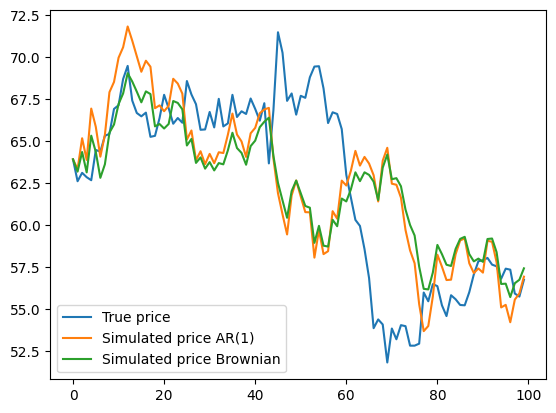

In [209]:
T = 100

S_t = np.zeros(shape=(T))
S_t[0] = S_lag[0]


for j in range(1, T):
    S_t[j] = drift + phi*S_t[j-1] + time_drift*j + ser*w[j-1]

plt.plot(range(T), S_lag[:T], label='True price')
plt.plot(range(T), S_t, label='Simulated price AR(1)')
plt.plot(range(T), S_t_bm, label='Simulated price Brownian')
plt.legend()
plt.show()